# CV part one

В этой тетрадке мы рассмотрим задачу распознавания лиц на примере датасета [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

**Предполагаем, что ноутбук запущен внутри Yandex DataSphere**

In [1]:
#!L
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision.models import resnet34
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import datetime
from PIL import Image
from copy import deepcopy
from collections import defaultdict

import os
from sklearn.metrics import pairwise_distances

%enable_full_walk

## Data

Качаем архив с данными с Yandex Object Storage и распаковываем в текущую папку.

Структура архива:
- /celeba_data/
    - train.csv
    - val.csv
    - images/{image}.jpg

CSV файлы содержат название файла (`image`) и его лейбл (`label`).

In [2]:
#!L
# from cloud_ml.storage.api import Storage

# s3 = Storage.s3(access_key="Le9tg70HQEJsoGqjqXH8", secret_key="NV75mCPkC0PEd35ImyDI5vI7p40YGFOYZgkH7moa")
# # downloading contents of the remote file into the local one
# s3.get('dl-hse-2021/celeba_data.zip', './celeba_data.zip')

In [3]:
#!L
# #!:bash
# unzip -q ./celeba_data.zip -d ./ && rm celeba_data.zip

## Задание 1
**(0.2 балла)** Напишите класс датасет, который будет возвращать картинку и ее лейбл.

In [4]:
#!L
mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
std =  torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)

class CelebADataset(Dataset):
    def __init__(self,  csv = 'celeba_data/train.csv',
                img_directory = 'celeba_data/images/'):
        self.directory = img_directory
        self.df = pd.read_csv(csv).to_dict('list')

    def __len__(self):
        return len(self.df['image'])
    
    def __getitem__(self, index):
        img_name = str(self.df['image'][index])
        img_name = os.path.join(self.directory, img_name)
        image = Image.open(img_name)
        transform = transforms.Compose([transforms.ToTensor()]) 
        image = transform(image) 
        image = (image - mean) / std
        label = self.df['label'][index]
        sample = dict(
            sample=image,
            label=label,
        )
        return sample

In [5]:
#!L
train_data = CelebADataset(csv='celeba_data/train.csv', img_directory = 'celeba_data/images/')
val_data = CelebADataset(csv='celeba_data/val.csv', img_directory = 'celeba_data/images/')

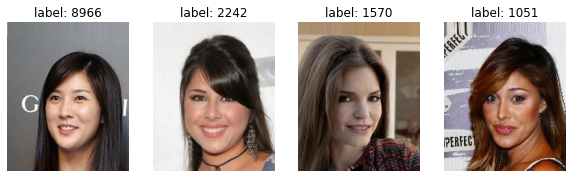

In [6]:
#!L
def show_examples(dataset: Dataset, num_examples: int = 4):
    fig, ax = plt.subplots(1, num_examples, figsize=(10, 10))
    
    for i in range(num_examples):
        # для визуализации вернем картинку к исходному значению
        k = np.random.randint(0, 60000)
        img, label = (dataset[k]['sample'] * std + mean).permute(1, 2, 0), dataset[k]['label']
        ax[i].imshow(img)
        ax[i].set_title(f'label: {label}')
        ax[i].axis('off')
    plt.show()
    
show_examples(dataset=train_data)

## Задание 2
**(0.2 балла)** Напишите функцию, которая будет считать метрику top-n accuracy.

$$TopN \ Accuracy = \frac{Number \ of \ objects \ with \ correct \ answer \ among \ topN \ predictions}{Total \ number \ of \ objects}$$

*Example:*

![image](https://www.baeldung.com/wp-content/ql-cache/quicklatex.com-ae746981c7a437b7e1fc2831e5d76d57_l3.svg)  
$Top3 \ Accuracy = \frac{4}{5} = 0.8$

*Hint:* Для каждого объекта выбираем `n` наиболее уверенных предсказаний. Если среди них есть правильный ответ, то увеличиваем числитель и знаменатель на единицу, иначе увеличиваем только знаменатель.

Тут очень хитрый подсчет, но он корректно работает, если у нас лейблы не повторяются в одной строке, что от нас и требуется.

In [7]:
#!L
def top_n_accuracy(preds: np.ndarray,
                   targets: np.ndarray,
                   n_size: int) -> float:
    matrix = preds[:, :n_size].T - targets
    non_zeros = np.count_nonzero(matrix, axis=None)
    zeros = matrix.shape[0] * matrix.shape[1] - non_zeros
    accuracy = zeros/matrix.shape[1]
    return accuracy

In [8]:
#!L
# быстрая проверка
preds = np.array([[1, 2, 3],[3, 4, 5], [5, 3, 1]])
targets = np.array([3, 3, 3])
n_size = 2
top_n_accuracy(preds, targets, n_size)

0.6666666666666666

## Задание 3
**(0.2 балла)** Решите задачу без дообучения.

*Step-by-step:*
1. Инициализируйте предобученную сетку (`backbone`).
1. Прогоните через нее все картинки из валидационного датасета и сложите полученные эмбеддинги в массив.
1. Для каждого вектора найдите ближайшие к нему векторы и отсортируйте их по расстоянию (cosine, euclidian, ...). Лейблы соседних векторов будут предсказаниями для текущего вектора.
1. Оставьте топ-5 уникальных предсказаний.
1. Посчитайте и выведите метрики:
    1. top-1 accuracy
    1. top-5 accuracy

*Вопросы:*
1. Зачем мы заменяем последний линейный слой на `Identity` ?
1. Зачем используем на сетке метод `eval` ?

*Hints:*
1. Для расчета попарных расстояний лучше не использовать циклы, а считать все в матрицах. Описание подхода к расчету L2 расстояний: [link](https://math.stackexchange.com/questions/3147549/compute-the-pairwise-euclidean-distance-matrix)
1. Так можно использовать sklearn реализации: [link](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.pairwise)
1. Для получения top-k предсказаний не обязательно сортировать весь массив.

*Ответы:*
1. В предтреннированный резнет учился на Imagenet, в котором количество уникальных labels составляет 1000, а если мы посмотрим на датасет CelebA, то мы увидими, что уникальных лейблов там больше. Поэтому нам надо менять fc слой. Это можно сделать через `Identity`, который позволяет согласовать нестыковки в архитектуре модели. 
2. `eval` используется, когда мы хотим посмотреть на результаты модели, а ни когда мы хотим тренировать модель. Хорошая практика - также использовать `torch.no_grad()` чтобы не менять градиенты. А так вообще `eval` позволяет переключить некоторые функции в другой режим, например, BatchNorm при обучении и тексте себе ведет по разному. И чтобы посмотерть на результат человеческим глазом  надо применить метод `eval`.

In [9]:
#!L
backbone = resnet34(pretrained=True)
backbone.fc = nn.Identity()
backbone = backbone.eval()

In [10]:
#!L
# мы уже использовали такой код в одной из дз
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.cuda.FloatTensor([])
    all_labels = torch.cuda.FloatTensor([])
    for batch in tqdm(loader):
        images = batch['sample'].view(-1, 3, 218, 178)
        labels = batch['label']
        images = images.cuda()
        labels = labels.cuda()
        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        ).cuda()
        all_labels = torch.cat(
            (all_labels, labels)
            ,dim=0
        )
    return all_preds.cpu().numpy(), all_labels.int().cpu().numpy()

with torch.no_grad():
    prediction_loader = DataLoader(val_data, shuffle=False, pin_memory=True, batch_size=128)
    val_preds, val_labels = get_all_preds(backbone.cuda(), prediction_loader)

100%|██████████| 156/156 [01:36<00:00,  1.62it/s]


In [11]:
#!L
# https://stackoverflow.com/questions/12926898/numpy-unique-without-sort
def unique(array, n):
    uniq, index = np.unique(array, return_index=True)
    return uniq[index.argsort()][:n]

def count_accuracy(preds, labels, n=(1, 5)):
    # первый указывает сам на себя
    inx = np.argsort(pairwise_distances(preds, metric='euclidean', n_jobs=-1))[:, 1:]
    predictions = np.zeros((inx.shape[0], max(n)))
    for i in tqdm(range(inx.shape[0])):
        predictions[i] = unique(labels[inx[i]], max(n))
    answers = np.zeros(len(n))
    for i in range(len(n)):
        answers[i] = top_n_accuracy(predictions, labels, n[i])
    return answers

In [12]:
#!L
top_1, top_5 = count_accuracy(val_preds, val_labels)
print('''Top 1 accuracy is {}
{}
Top 5 accuracy is {}.'''.format(top_1, '-'*40, top_5))

100%|██████████| 19867/19867 [00:34<00:00, 567.96it/s]


Top 1 accuracy is 0.18090300498313786
----------------------------------------
Top 5 accuracy is 0.291639402023456.


## Задание 4
**(0.4 балла)** Решите задачу с дообучением на эмбеддингах.

*Step-by-step:*
1. Напишите небольшую сетку произвольной архитектуры, которая будет использовать эмбеды, выдаваемые `backbone` сетью.
1. Напишите класс Dataset, который будет возвращать эмбединг и лейбл.
1. Напишите класс Sampler [PyTroch docs](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler), который будет отвечать за правильность сбора тренировочных батчей: якорный пример, позитивный, негативный.
1. Обучите ее на тренировочном датасете:
    1. Лосс -- [triplet loss](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html).
    1. Метрика -- top-5 accuracy.
1. Посчитайте top-1 и top-5 accuracy на валидации. Насколько сильно они отличаются от того, что получилось в предыдущем задании?


*Hints:*
1. Убедитесь, что у каждого лейбла есть как минимум 2 примера, иначе не получится достать позитивный пример.
1. Лучше предварительно прогнать все картинки из трейна и сохранить полученные эмбеддинги, чтобы при обучении сети грузить только эмбеды (векторы).

In [13]:
#!L
with torch.no_grad():
    prediction_loader = DataLoader(train_data, shuffle=False, pin_memory=True, batch_size=128)
    train_preds, train_labels = get_all_preds(backbone.cuda(), prediction_loader)

100%|██████████| 1272/1272 [13:25<00:00,  1.58it/s]


Есть очень прикольная библиотека, которая позволяет сгенерировать правильные триплета, давайте будем ей пользоваться.

In [14]:
#!L
# https://github.com/KevinMusgrave/pytorch-metric-learning/blob/master/examples/notebooks/TripletMarginLossMNIST.ipynb
# %pip install pytorch_metric_learning
from pytorch_metric_learning import losses, miners, reducers
from pytorch_metric_learning.distances import CosineSimilarity

In [15]:
#!L
class CelebAEmbeddingDataset(Dataset):
    def __init__(self, preds: np.ndarray,
                     labels: np.ndarray):
        if len(preds) != len(labels):
            raise ValueError('labels and preds must have equal number of elements')
        self.preds = preds
        self.labels = labels
        

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        sample = dict(
            preds=self.preds[index],
            label=self.labels[index],
        )
        return sample

    
class CelebATripletSampler(Sampler):
    def __init__(self, dataset: Dataset):
        super().__init__(dataset)
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __iter__(self):
        for anchor_idx in range(len(self.dataset)):
            positive_idx = self._mine_positive(anchor_idx)

            yield anchor_idx
            yield positive_idx
            
    # здесь почти тоже самое, что и в примере. Будем подавать в батче anchor, positive. А модель уже разберется какие негативные примеры к ним подобрать.
    def _mine_positive(self, anchor_idx: int):
        labels: np.ndarray = self.dataset.labels

        anchor_label = labels[anchor_idx]
        pos_idxs = np.nonzero(labels == anchor_label)
        pos_idx = np.random.choice(pos_idxs[0])

        return pos_idx

Возможно пора писать трейнер и модель в отдельном файле. Начну делать так со следующего дз. На сколько будет удобно проверять дз в таком формате?

In [16]:
#!L
class myMLP(nn.Module):
    def __init__(self,
                 backbone_exit: int = 512, 
                 ):
        super().__init__()
        self.backbone_exit = backbone_exit
        self.inner = nn.Sequential(nn.Linear(backbone_exit, 1024), 
                                  nn.ReLU(),
                                  nn.Linear(1024, backbone_exit), 
                                  nn.BatchNorm1d(backbone_exit))
        
    
    def forward(self, x):
        return F.normalize(self.inner(x))

    
    def compute_all(self, batch):
        x = batch['preds'] 
        y = batch['label']
        embeds = self.forward(x)
        
        # вот тут вступает в игру наша библиотека по майнингу триплетов
        idx_triplets = miner(embeds, y)
        loss = loss_function(embeds, y, idx_triplets)
        
        return loss

class Trainer:
    def __init__(self, model: nn.Module,
                 optimizer,
                 train_dataset: Dataset,
                 val_dataset: Dataset,
                 train_sampler: Sampler = None,
                 val_sampler: Sampler = None,
                 tboard_log_dir: str = "results/",
                 batch_size: int = 128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size
        self.train_sampler = train_sampler
        self.val_sampler = val_sampler

        self.device = 'cuda'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        
        self.train_writer = SummaryWriter(log_dir=tboard_log_dir + "train/" \
                                          + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
        self.val_writer = SummaryWriter(log_dir=tboard_log_dir + "val/" \
                                        + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
        self.cache = self.cache_states()

    def save_checkpoint(self, path):
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs: int):
        model = self.model
        optimizer = self.optimizer
        
        if self.train_sampler is None:
            shuffle=True
        else:
            shuffle=False
        train_loader = DataLoader(self.train_dataset, pin_memory=True, shuffle=shuffle, batch_size=self.batch_size, sampler=self.train_sampler)
        val_loader = DataLoader(self.val_dataset, pin_memory=True, shuffle=False, batch_size=self.batch_size, sampler=self.val_sampler)
        best_loss = float('inf')

        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss = model.compute_all(batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            
                self.train_writer.add_scalar(f'loss', loss, global_step=self.global_step)
                self.global_step += 1
    

            model.eval()
            val_losses = []
                
            for batch in tqdm(val_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss = model.compute_all(batch)
                val_losses.append(loss.item())
                                  
            val_loss = np.mean(val_losses)

            self.val_writer.add_scalar(f'loss', val_loss, global_step=self.global_step)

            if val_loss < best_loss:
                self.save_checkpoint("./best_checkpoint.pth")
                best_loss = val_loss
                                  
            print('[{} epoch] - loss {}'.format(epoch+1, val_loss))
            
    def find_lr(self, min_lr: float = 1e-6,
                max_lr: float = 1e-1,
                num_lrs: int = 20,
                smooth_beta: float = 0.8) -> dict:
        lrs = np.geomspace(start=min_lr, stop=max_lr, num=num_lrs)
        logs = {'lr': [], 'loss': [], 'avg_loss': []}
        avg_loss = None
        model, optimizer = self.model, self.optimizer
        
        train_loader = DataLoader(self.train_dataset, pin_memory=True, shuffle=False, batch_size=self.batch_size, sampler=self.train_sampler)

        model.train()
        for lr, batch in tqdm(zip(lrs, train_loader), desc='finding LR', total=num_lrs):
            # apply new lr
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr

            # train step
            batch = {k: v.to(self.device) for k, v in batch.items()}
            loss = model.compute_all(batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate smoothed loss
            if avg_loss is None:
                avg_loss = loss
            else:
                avg_loss = smooth_beta * avg_loss + (1 - smooth_beta) * loss

            # store values into logs
            logs['lr'].append(lr)
            logs['avg_loss'].append(avg_loss)
            logs['loss'].append(loss)
            
        for k, v in logs.items():
            for i in range(len(v)):
                self.train_writer.add_scalar(k, v[i], global_step=self.global_step)
                self.global_step += 1

        logs.update({key: np.array(val) for key, val in logs.items()})
        self.rollback_states()

        return logs

    def cache_states(self):
        cache_dict = {'model_state': deepcopy(self.model.state_dict()),
                      'optimizer_state': deepcopy(self.optimizer.state_dict())}

        return cache_dict

    def rollback_states(self):
        self.model.load_state_dict(self.cache['model_state'])
        self.optimizer.load_state_dict(self.cache['optimizer_state'])
            

    def cache_states(self):
        cache_dict = {'model_state': deepcopy(self.model.state_dict()),
                      'optimizer_state': deepcopy(self.optimizer.state_dict())}

        return cache_dict

    def rollback_states(self):
        self.model.load_state_dict(self.cache['model_state'])
        self.optimizer.load_state_dict(self.cache['optimizer_state'])

In [17]:
#!L
train_data_emb = CelebAEmbeddingDataset(train_preds, train_labels)
val_data_emb = CelebAEmbeddingDataset(val_preds, val_labels)
train_trilplet_sampler = CelebATripletSampler(train_data_emb)
val_trilplet_sampler = CelebATripletSampler(val_data_emb)

In [18]:
#!L
miner = miners.TripletMarginMiner(margin = 0.2, distance = CosineSimilarity(), type_of_triplets = "hard")
reducer = reducers.ThresholdReducer(low = 0)
loss_function = losses.TripletMarginLoss(margin = 0.2, distance = CosineSimilarity(), reducer = reducer)

In [19]:
#!L
MLP = myMLP()
opt = optim.Adam(MLP.parameters(), lr=5e-4)
trainer = Trainer(model = MLP, optimizer = opt, train_dataset = train_data_emb, 
                  val_dataset = val_data_emb, batch_size=512,
                 train_sampler=train_trilplet_sampler, val_sampler=val_trilplet_sampler)

Выберем оптимальный learning rate для нашей модели.

In [20]:
#!L
logs = trainer.find_lr(min_lr = 1e-6,
                max_lr = 1e-2,
                num_lrs = 200,
                smooth_beta = 0.8)

finding LR: 100%|██████████| 200/200 [00:15<00:00, 13.22it/s]


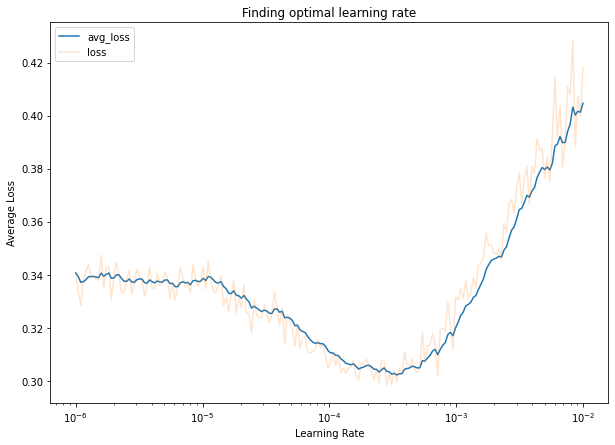

In [21]:
#!L
plt.figure(figsize=(10,7))
plt.plot(logs['lr'], logs['avg_loss'], label='avg_loss')
plt.plot(logs['lr'], logs['loss'], alpha=0.2, label='loss')
plt.xlabel('Learning Rate')
plt.ylabel('Average Loss')
plt.xscale('log')
plt.title('Finding optimal learning rate')
plt.legend()
plt.show()

In [22]:
#!L
MLP = myMLP()
opt = optim.Adam(MLP.parameters(), lr=1e-4)
trainer = Trainer(model = MLP, optimizer = opt, train_dataset = train_data_emb, 
                  val_dataset = val_data_emb, batch_size=512,
                 train_sampler=train_trilplet_sampler, val_sampler=val_trilplet_sampler)

In [23]:
#!L
trainer.train(5)

636it [00:47, 13.35it/s]                         
78it [00:04, 18.81it/s]                        
  1%|          | 2/318 [00:00<00:23, 13.60it/s]

[1 epoch] - loss 0.28246625990439683


636it [00:47, 13.49it/s]                         
78it [00:04, 18.20it/s]                        
  1%|          | 2/318 [00:00<00:23, 13.34it/s]

[2 epoch] - loss 0.2771885624298683


636it [00:47, 13.40it/s]                         
78it [00:04, 18.85it/s][00:02<00:00, 18.74it/s]
  1%|          | 2/318 [00:00<00:23, 13.73it/s]

[3 epoch] - loss 0.2752809730859903


636it [00:47, 13.46it/s]                         
78it [00:04, 18.63it/s]                        
  0%|          | 0/318 [00:00<?, ?it/s]

[4 epoch] - loss 0.2723667820294698


636it [00:47, 13.42it/s]                         
78it [00:04, 18.72it/s][00:02<00:00, 18.65it/s]


[5 epoch] - loss 0.2714531830488107


In [24]:
#!L
MLP = MLP.eval()

@torch.no_grad()
def get_all_embeds(model, loader):
    all_embeds = torch.cuda.FloatTensor([])
    all_labels = torch.cuda.FloatTensor([])
    for batch in tqdm(loader):
        preds = batch['preds'].cuda()
        labels = batch['label'].cuda()
        embeds = model.forward(preds)
        all_embeds = torch.cat(
            (all_embeds, embeds)
            ,dim=0
        ).cuda()
        all_labels = torch.cat(
            (all_labels, labels)
            ,dim=0
        )
    return all_embeds.cpu().numpy(), all_labels.int().cpu().numpy()

with torch.no_grad():
    prediction_loader = DataLoader(val_data_emb, shuffle=False, pin_memory=True, batch_size=128)
    all_embeds, all_labels = get_all_embeds(MLP.cuda(), prediction_loader)

100%|██████████| 156/156 [00:00<00:00, 455.72it/s]


In [25]:
#!L
top_1, top_5 = count_accuracy(all_embeds, all_labels)
print('''Top 1 accuracy is {}
{}
Top 5 accuracy is {}.'''.format(top_1, '-'*40, top_5))

100%|██████████| 19867/19867 [00:33<00:00, 587.04it/s]


Top 1 accuracy is 0.23234509488095836
----------------------------------------
Top 5 accuracy is 0.3898927870337746.


Вроде неплохой результат, обучение с маленькой сеткой на эмбединга backbone на топ 5 accuracy позволило нам увеличить accuracy на 10%.

## Sampler (simple example)

В блоках ниже реализован пример датасета и сэмлера, который возвращает индексы для триплет лосса.

Датасет написан топорно, но основная логика следующая. Если ему на вход приходит `int`, то он возвращает название картинки (`img_name`) и ее лейбл (`img_label`). Если же приходит нечто длиной 3, то он возвращает 3 названия картинок, соответственно. В нашем случае это будет три картинки с двумя одинаковыми лейблами и одним другим: anchor, positive, negative.  
Сэмплер `SimpleTripletSampler`, в свою очередь, отвечает за формирование и поставку в датасет индексов триплетов.

Датасет и сэмлер объединяются внутри даталоадера.

*Hint:* Код написан только лишь для примера, поэтому логика возвращения триплетов может быть неверной.

In [26]:
#!L
class SimpleDataset(Dataset):
    def __init__(self, img_names: np.ndarray,
                 img_labels: np.ndarray):
        if len(img_names) != len(img_labels):
            raise ValueError('img_names and img_labels must have equal number of elements')

        self.img_names = img_names
        self.img_labels = img_labels

    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        if isinstance(idx, int):
            img_name = self.img_names[idx]
            img_label = self.img_labels[idx]
            
            return img_name, img_label
        else:
            assert len(idx) == 3
            
            anc_idx, pos_idx, neg_idx = idx
            anc_img_name = self.img_names[anc_idx]
            pos_img_name = self.img_names[pos_idx]
            neg_img_name = self.img_names[neg_idx]

            return anc_img_name, pos_img_name, neg_img_name


class SimpleTripletSampler(Sampler):
    def __init__(self, dataset: Dataset):
        super().__init__(dataset)

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __iter__(self):
        for anchor_idx in range(len(self.dataset)):
            positive_idx = self._mine_positive(anchor_idx)
            negative_idx = self._mine_negative(anchor_idx)

            yield anchor_idx, positive_idx, negative_idx

    def _mine_positive(self, anchor_idx: int):
        labels: np.ndarray = self.dataset.img_labels

        anchor_label = labels[anchor_idx]
        pos_idxs = np.nonzero(labels == anchor_label)[0]
        pos_idx = np.random.choice(pos_idxs)

        return pos_idx

    def _mine_negative(self, anchor_idx: int):
        labels: np.ndarray = self.dataset.img_labels

        anchor_label = labels[anchor_idx]
        neg_idxs = np.nonzero(labels != anchor_label)[0]
        neg_idx = np.random.choice(neg_idxs)

        return neg_idx

In [27]:
#!L
ex_size = 100
np.random.seed(42)

# в нашем примере названием картинки будет выступать число от 0 до 99, а лейблом число от 0 до 4.
ex_dataset = SimpleDataset(img_names=np.arange(ex_size),
                           img_labels=np.random.randint(0, 5, size=ex_size))
ex_sampler = SimpleTripletSampler(dataset=ex_dataset)

ex_loader = DataLoader(dataset=ex_dataset, batch_size=10, sampler=ex_sampler)
ex_batch = next(iter(ex_loader))

ex_batch_anc_labels = ex_dataset.img_labels[ex_batch[0]]
ex_batch_pos_labels = ex_dataset.img_labels[ex_batch[1]]
ex_batch_neg_labels = ex_dataset.img_labels[ex_batch[2]]

In [28]:
#!L
# В этой ячейке мы дергаем первый батч с названиями картинок и достаем их лейблы, 
#  чтобы проверить действительно ли у них одинаковые или разные лейблы.
# Для тренировки сети с триплет лоссом сами лейблы нам не нужны будут.
#  Главное чтобы триплеты картинок формировались правильно: anchor, positive, negative

ex_batch = next(iter(ex_loader))

ex_batch_anc_labels = ex_dataset.img_labels[ex_batch[0]]
ex_batch_pos_labels = ex_dataset.img_labels[ex_batch[1]]
ex_batch_neg_labels = ex_dataset.img_labels[ex_batch[2]]

In [29]:
#!L
print('All anchor and positive labels are equal:', np.all(ex_batch_anc_labels == ex_batch_pos_labels))
print('Any of anchor and negative labels are equal:', np.any(ex_batch_anc_labels == ex_batch_neg_labels))

All anchor and positive labels are equal: True
Any of anchor and negative labels are equal: False


In [ ]:
#!L
